# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [1]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
from tensorflow.keras import optimizers


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))


In [3]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

#batch_size = 32
num_classes = 10
#epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


In [4]:

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def get_model():

    #    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊

    model = Sequential()

    #   第二步：構建網絡層
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
    model.add(Activation('softmax')) # 最後一層用softmax作為激活函數
    
    return model

In [9]:
model = get_model()

In [10]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [11]:
# 輸出模型摘要資訊
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [18]:
def experience(epochs, batch_size, opt):
    
    model = get_model()
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    if not data_augmentation:
        print('Not using data augmentation.')
        history=model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    
    else:
        print('Using real-time data augmentation.')
        print('')
        
    # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   
    
    print('')
    
    # Score trained model.
    print('Scoring trained model.')
    scores = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 20s 408us/sample - loss: 1.5485 - accuracy: 0.4340 - val_loss: 1.1706 - val_accuracy: 0.5807
Epoch 2/10
50000/50000 [==============================] - 18s 367us/sample - loss: 1.1771 - accuracy: 0.5803 - val_loss: 1.0288 - val_accuracy: 0.6329
Epoch 3/10
50000/50000 [==============================] - 19s 371us/sample - loss: 1.0285 - accuracy: 0.6348 - val_loss: 0.8923 - val_accuracy: 0.6845
Epoch 4/10
50000/50000 [==============================] - 18s 368us/sample - loss: 0.9287 - accuracy: 0.6751 - val_loss: 0.9252 - val_accuracy: 0.6861
Epoch 5/10
50000/50000 [==============================] - 19s 373us/sample - loss: 0.8684 - accuracy: 0.6957 - val_loss: 0.8086 - val_accuracy: 0.7166
Epoch 6/10
50000/50000 [==============================] - 19s 374us/sample - loss: 0.8132 - accuracy: 0.7154 - val_loss: 0.7532 - val_accuracy: 0.7404
Epoch 7/

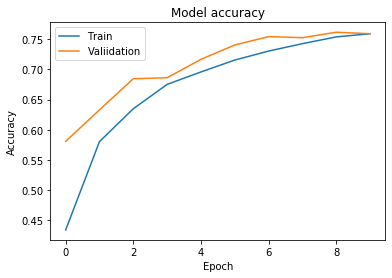

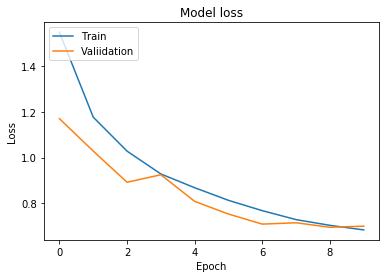

In [20]:
#Adam epochs=10 batch_size=32
experience(epochs=10, batch_size=32, opt='adam')

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 213us/sample - loss: 1.5919 - accuracy: 0.4167 - val_loss: 1.2315 - val_accuracy: 0.5657
Epoch 2/10
50000/50000 [==============================] - 9s 184us/sample - loss: 1.2093 - accuracy: 0.5683 - val_loss: 1.0424 - val_accuracy: 0.6312
Epoch 3/10
50000/50000 [==============================] - 9s 186us/sample - loss: 1.0303 - accuracy: 0.6358 - val_loss: 0.9308 - val_accuracy: 0.6765
Epoch 4/10
50000/50000 [==============================] - 9s 184us/sample - loss: 0.9171 - accuracy: 0.6776 - val_loss: 0.8515 - val_accuracy: 0.7030
Epoch 5/10
50000/50000 [==============================] - 9s 186us/sample - loss: 0.8398 - accuracy: 0.7064 - val_loss: 0.7582 - val_accuracy: 0.7362
Epoch 6/10
50000/50000 [==============================] - 9s 185us/sample - loss: 0.7660 - accuracy: 0.7314 - val_loss: 0.7128 - val_accuracy: 0.7486
Epoch 7/10
50

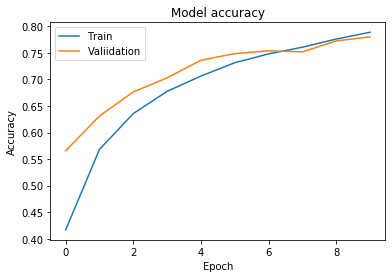

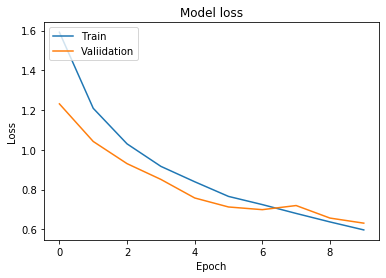

In [19]:
#Adam epochs=10 batch_size=128
experience(epochs=10, batch_size=128, opt='adam')

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 14s 278us/sample - loss: 1.5609 - accuracy: 0.4277 - val_loss: 1.1914 - val_accuracy: 0.5771
Epoch 2/20
50000/50000 [==============================] - 12s 249us/sample - loss: 1.1419 - accuracy: 0.5943 - val_loss: 0.9697 - val_accuracy: 0.6558
Epoch 3/20
50000/50000 [==============================] - 13s 250us/sample - loss: 0.9792 - accuracy: 0.6518 - val_loss: 0.8756 - val_accuracy: 0.6927
Epoch 4/20
50000/50000 [==============================] - 13s 251us/sample - loss: 0.8763 - accuracy: 0.6891 - val_loss: 0.7999 - val_accuracy: 0.7197
Epoch 5/20
50000/50000 [==============================] - 12s 248us/sample - loss: 0.8078 - accuracy: 0.7154 - val_loss: 0.8342 - val_accuracy: 0.7100
Epoch 6/20
50000/50000 [==============================] - 13s 251us/sample - loss: 0.7538 - accuracy: 0.7342 - val_loss: 0.7084 - val_accuracy: 0.7557
Epoch 7/

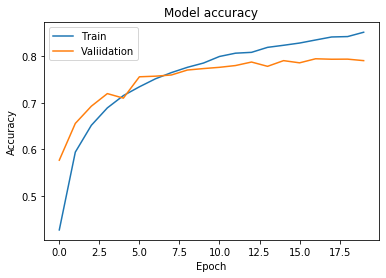

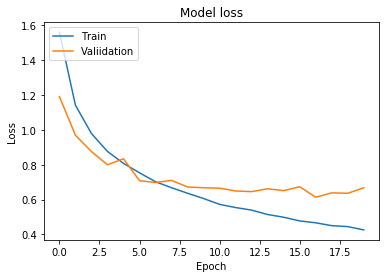

In [22]:
#Adam epochs=20 batch_size=64
experience(epochs=20, batch_size=64, opt='adam')

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 264us/sample - loss: 2.1839 - accuracy: 0.1812 - val_loss: 2.0004 - val_accuracy: 0.2745
Epoch 2/20
50000/50000 [==============================] - 12s 241us/sample - loss: 1.9539 - accuracy: 0.2897 - val_loss: 1.8578 - val_accuracy: 0.3311
Epoch 3/20
50000/50000 [==============================] - 12s 240us/sample - loss: 1.7961 - accuracy: 0.3486 - val_loss: 1.7592 - val_accuracy: 0.3720
Epoch 4/20
50000/50000 [==============================] - 12s 239us/sample - loss: 1.6807 - accuracy: 0.3887 - val_loss: 1.6592 - val_accuracy: 0.4055
Epoch 5/20
50000/50000 [==============================] - 12s 240us/sample - loss: 1.5926 - accuracy: 0.4205 - val_loss: 1.4549 - val_accuracy: 0.4738
Epoch 6/20
50000/50000 [==============================] - 12s 242us/sample - loss: 1.5287 - accuracy: 0.4424 - val_loss: 1.4211 - val_accuracy: 0.4835
Epoch 7/

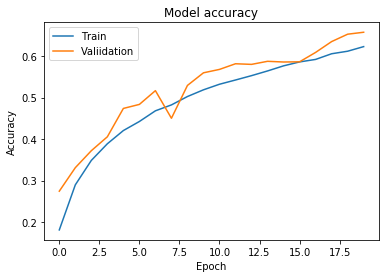

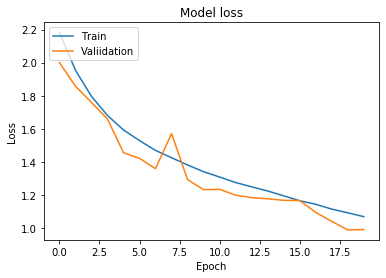

In [23]:
#SGD
experience(epochs=20, batch_size=64, opt='SGD')

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 15s 292us/sample - loss: 1.6334 - accuracy: 0.4081 - val_loss: 1.2659 - val_accuracy: 0.5441
Epoch 2/20
50000/50000 [==============================] - 13s 259us/sample - loss: 1.1643 - accuracy: 0.5900 - val_loss: 1.2177 - val_accuracy: 0.5837
Epoch 3/20
50000/50000 [==============================] - 13s 257us/sample - loss: 0.9856 - accuracy: 0.6558 - val_loss: 0.8697 - val_accuracy: 0.6998
Epoch 4/20
50000/50000 [==============================] - 13s 260us/sample - loss: 0.8898 - accuracy: 0.6901 - val_loss: 0.9950 - val_accuracy: 0.6661
Epoch 5/20
50000/50000 [==============================] - 13s 258us/sample - loss: 0.8301 - accuracy: 0.7145 - val_loss: 0.8802 - val_accuracy: 0.6998
Epoch 6/20
50000/50000 [==============================] - 13s 257us/sample - loss: 0.7994 - accuracy: 0.7252 - val_loss: 0.8102 - val_accuracy: 0.7291
Epoch 7/

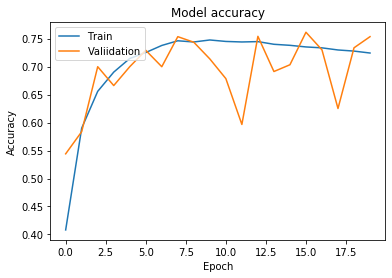

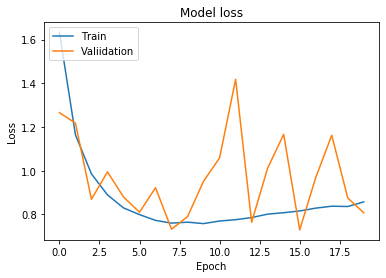

In [24]:
#Rmsprop
experience(epochs=20, batch_size=64, opt='Rmsprop')